In [32]:
# Libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [18]:
# read the listings dataset
listingsDF = pd.read_csv('listings.csv')

# find number of hosts and number of listings
hosts_num = len(listingsDF['host_id'].unique())
listings_num = listingsDF['id'].count()

print('listings.csv dataset contains information on %d listings provided by %d hosts.' % (listings_num,
                                                                                          hosts_num))

listings.csv dataset contains information on 7747 listings provided by 3590 hosts.


In [19]:
# read the calendar dataset
calendarDF = pd.read_csv('calendar.csv')

# find number of rows in dataset
rows = calendarDF.shape[0]

# find first and last date of the calendar
first_date = calendarDF['date'].min()
last_date = calendarDF['date'].max()

print('Calendar Dataset contains %d rows.' % (rows))
print('The First date of observation is %s and the Last date is %s.' % (first_date, last_date))

Calendar Dataset contains 2827655 rows.
The First date of observation is 2023-03-19 and the Last date is 2024-03-17.


In [20]:
# Helper functions for dataset cleaning

def get_month(row):
    ''' Get month from date represented as a string '''
    return int(row['date'].split('-')[1])


def get_year(row):
    ''' Get year from date represented as a string '''
    return int(row['date'].split('-')[0])


# Main dataset cleaning function
def clean_data(listings_df, calendar_df):
    # merge datasets
    listings_df = listings_df.rename(index=str, columns={"id": "listing_id"})
    df = pd.merge(calendar_df, listings_df, on='listing_id')

    columns_to_drop = ['available', 'host_id', 'name', 'neighbourhood', 'host_name', 'latitude', 'longitude',
                       'availability_365',
                       'last_review', 'license', 'price_y', 'reviews_per_month']

    df = df.drop(columns=columns_to_drop)
    print(df.columns)

    # convert date from the calendar into month and drop the date colum
    df['month'] = df.apply(lambda row: get_month(row), axis=1)
    df['year'] = df.apply(lambda row: get_year(row), axis=1)
    df = df.drop(columns=['date'])

    # remove rows where price_x == nan, because price will be used as response column
    df = df.dropna(subset=['price_x'])

    # convert price to number and drop the price_x column
    df['price'] = df['price_x'].astype(str)
    df['price'] = df['price'].str.replace("[$, ]", "").astype("float")
    df = df.drop(columns=['price_x'])

    return df

# apply functions above to clean dataset
df = clean_data(listingsDF, calendarDF)

Index(['listing_id', 'date', 'price_x', 'adjusted_price', 'minimum_nights_x',
       'maximum_nights', 'neighbourhood_group', 'room_type',
       'minimum_nights_y', 'number_of_reviews',
       'calculated_host_listings_count', 'number_of_reviews_ltm'],
      dtype='object')


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:36: FutureWarning: The default value of regex will change from True to False in a future version.


In [22]:
'''What are the main factors, which affect the reservation prices?'''

#find minimum, maximum and average price for listing
lowest_price = df['price'].min()
highest_price = df['price'].max()
average_price = df['price'].mean()

print('Lowest price per listing is %d$.' % (lowest_price))
print('Highest price per listing is %d$' % (highest_price))
print('Average price per listing is %d$.' % (average_price))

Lowest price per listing is 0$.
Highest price per listing is 99998$
Average price per listing is 214$.


In [25]:
# 99998$ is an absolute high value for which we need to remove outlliers from price
z_score = np.abs((df['price'] - df['price'].mean()) / np.std(df['price']))
print((z_score>3).count())

# Remove any rows where the z-score is greater than 3
df = df.drop(df[z_score > 3].index)


lowest_price = df['price'].min()
highest_price = df['price'].max()
average_price = df['price'].mean()

print('Lowest price per listing is %d$.' % (lowest_price))
print('Highest price per listing is %d$' % (highest_price))
print('Average price per listing is %d$.' % (average_price))

1761186
Lowest price per listing is 0$.
Highest price per listing is 849$
Average price per listing is 169$.


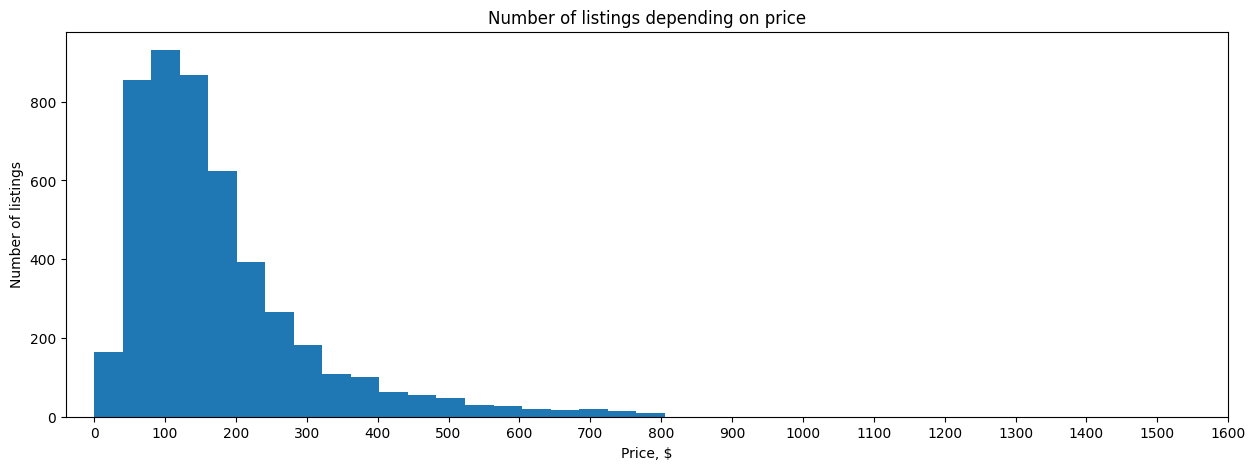

In [26]:
#get the average price for each listing
average_listing_price = df.groupby('listing_id').mean()['price']

#plot
plt.figure(figsize=(15,5))
plt.hist(average_listing_price, bins=20)
plt.xticks(np.arange(0, 1700, step=100))
plt.ylabel('Number of listings')
plt.xlabel('Price, $')
plt.title('Number of listings depending on price')


plt.savefig('Price Distrubution.png')

plt.show()

# Conclusion: Now we see the distribution of average listing prices. The majority of listings is concentrated around 50 - 250 USD

Conclusion: Now we see the distribution of average listing prices. The majority of listings is concentrated around 50 - 250 USD

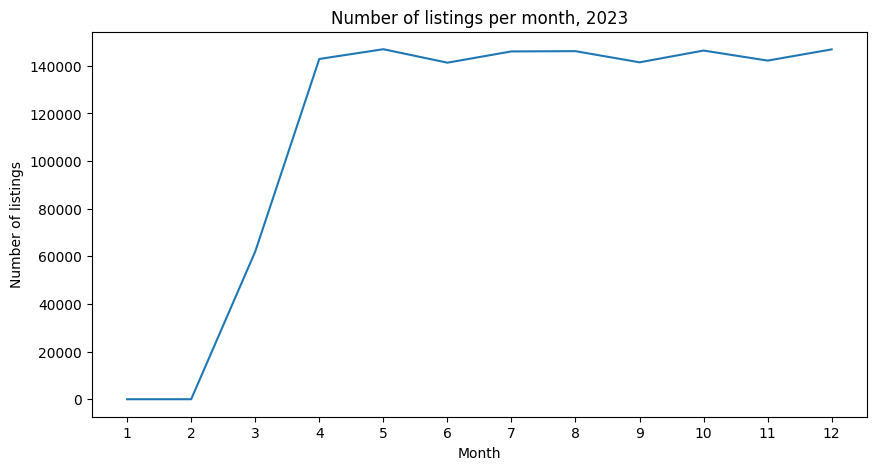

In [27]:
# find number of total number of listings for each month in 2023
listings_by_month = pd.Series([12])
for i in range(1, 13):
    listings_by_month[i] = len(df[(df['month'] == i) & (df['year'] == 2023)]['listing_id'])

listings_by_month = listings_by_month.drop(0)

# plot
plt.figure(figsize=(10, 5))
plt.plot(listings_by_month)
plt.xticks(np.arange(1, 13, step=1))
plt.ylabel('Number of listings')
plt.xlabel('Month')
plt.title('Number of listings per month, 2023')

plt.savefig('number of available listings.png')

plt.show()

# Conclusion: The diagram above shows us number of listings depending on month. We can see that number of available listings for reservation is tends to be higher from March and remains high for the next 9 months as well..

Conclusion: The diagram above shows us number of listings depending on month. We can see that number of available listings for reservation is tends to be higher from March and remains high for the next 9 months as well. Which means we can save money on the reservations as the listings are high these months.

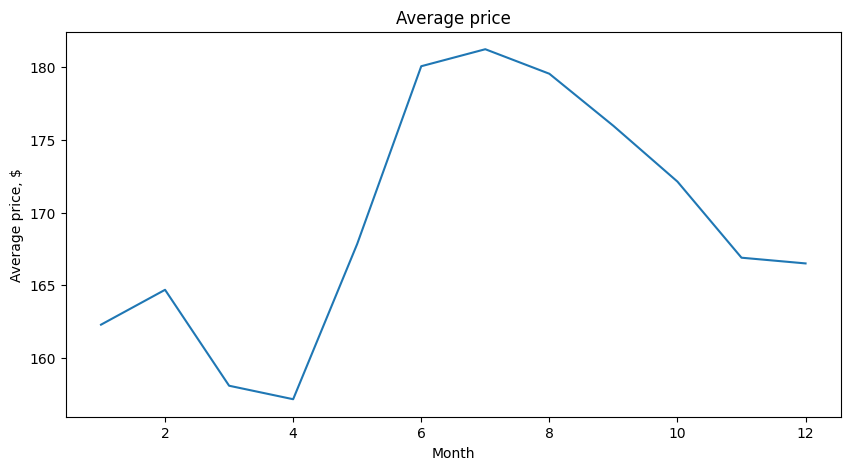

In [28]:
#find average price by month
average_price_each_month = df.groupby(['month'])['price'].mean()

#plot
plt.figure(figsize=(10,5))
plt.plot(average_price_each_month)
plt.ylabel('Average price, $')
plt.xlabel('Month')
plt.title('Average price')

plt.savefig('Average price each month')

plt.show()

# Conclusion: According to the diagram above listing prices raise significantly in summer, probably, because of the fact that there are less listings available for reservation. This tells us that summer holidays should be the busiest times to visit Seattle.


Conclusion: According to the diagram above listing prices raise significantly in summer, probably, because of the fact that there are less listings available for reservation. This tells us that summer holidays should be the busiest times to visit Seattle.

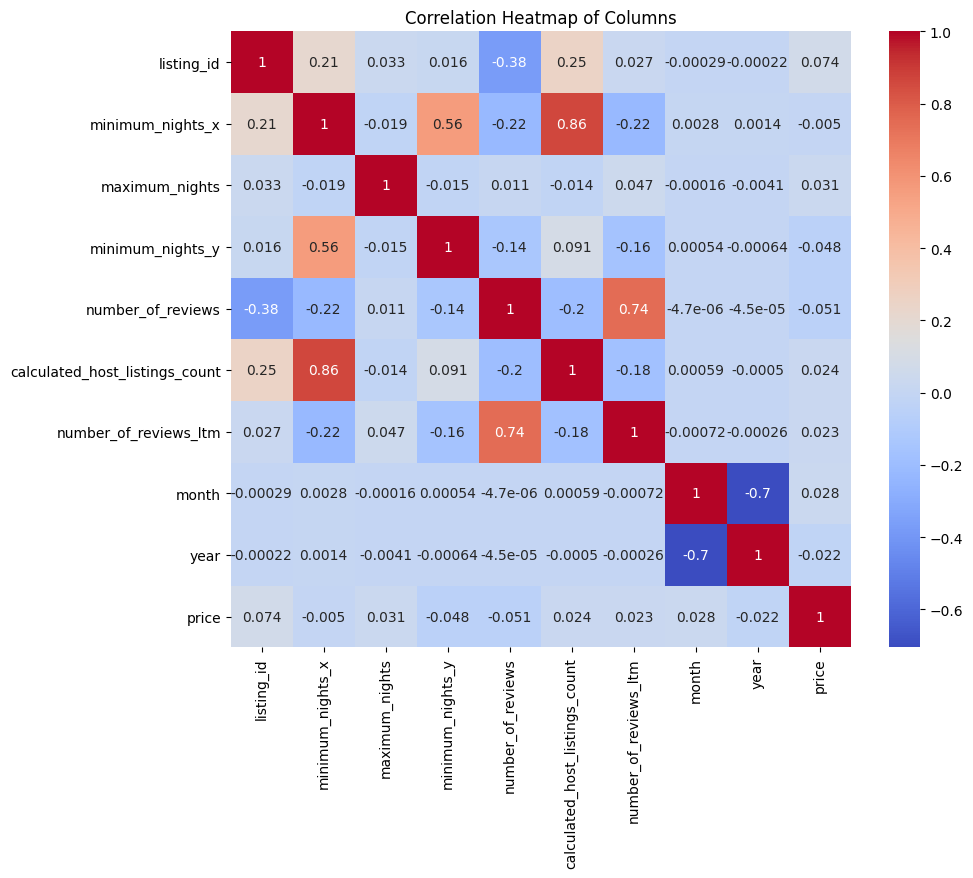

In [31]:
plt.figure(figsize=(10, 8))
df = df.drop(columns=['neighbourhood_group'])
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Columns')
plt.show()

Conclusion: Heatmap shows a week correlation among the direct attributes of the dataset